In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
test_path='/content/drive/MyDrive/test'
train_path='/content/drive/MyDrive/train'
valid_path='/content/drive/MyDrive/val' 

In [4]:
list_of_classes=['Stage - I', 'Stage - IV', 'Stage - V', 'Stage - II', 'Stage - III']

for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)


train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
          Stage - I                2286     
          Stage - II                757     
         Stage - III                173     
          Stage - IV               1046     
          Stage - V                1516     
Stage - I  has the most images=  2286   Stage - III  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [6]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)    

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


In [7]:
def relabel(label_in):
    if label_in =='Stage - I' or label_in == 'Stage - IV' or label_in =='Stage - V':
        label='Stage - I'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label


In [8]:
print (train_df['labels'].value_counts())

Stage - I      1500
Stage - II      500
Stage - III     500
Name: labels, dtype: int64


In [9]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [10]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


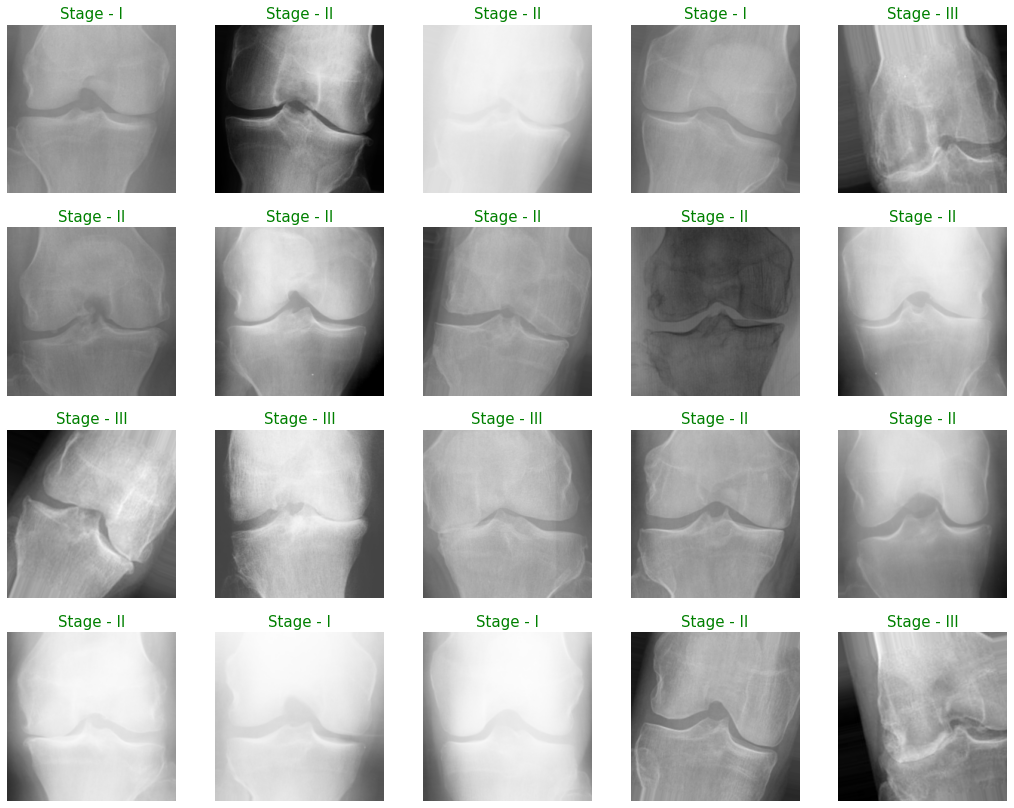

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(18, 18))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=15)
        plt.axis('off')
    plt.show()
show_image_samples(train_gen ) 

In [ ]:
pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 558.0 MB 21 kB/s 
     |████████████████████████████████| 439 kB 65.8 MB/s 
     |████████████████████████████████| 5.7 MB 5.3 MB/s 
     |████████████████████████████████| 1.7 MB 34.6 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [12]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB7'
base_model=EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 


179339264/258076736 [===================>..........] - ETA: 2s

KeyboardInterrupt: ignored

In [ ]:
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
from tensorflow.keras.applications.efficientnet import EfficientNetB7
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB7'
base_model=EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [ ]:
new_history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
75/75 [==============================] - ETA: 0s - loss: 8.7641 - accuracy: 0.5953
 validation loss of  8.6368 is below lowest loss, saving weights from epoch 1   as best weights
75/75 [==============================] - 560s 7s/step - loss: 8.7641 - accuracy: 0.5953 - val_loss: 8.6368 - val_accuracy: 0.8511
Epoch 2/40
75/75 [==============================] - ETA: 0s - loss: 6.5975 - accuracy: 0.7773
 validation loss of  9.4042 is above lowest loss of  8.6368 keeping weights from epoch 1 as best weights
75/75 [==============================] - 96s 1s/step - loss: 6.5975 - accuracy: 0.7773 - val_loss: 9.4042 - val_accuracy: 0.9068
Epoch 3/40
75/75 [==============================] - ETA: 0s - loss: 5.3152 - accuracy: 0.8700
 validation loss of  5.2971 is below lowest loss, saving weights from epoch 3   as best weights


In [ ]:
model.evaluate(test_gen)

23/23 [==============================] - 18s 759ms/step - loss: 0.9164 - accuracy: 0.9396


[0.9163689613342285, 0.9396135210990906]

23/23 [==============================] - 17s 760ms/step
there were 100 errors in 1656 tests for an accuracy of  93.96


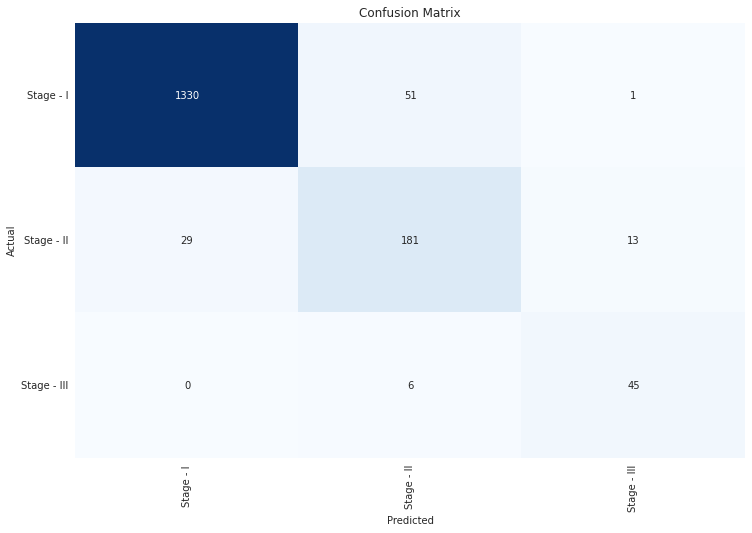

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.9787    0.9624    0.9704      1382
  Stage - II     0.7605    0.8117    0.7852       223
 Stage - III     0.7627    0.8824    0.8182        51

    accuracy                         0.9396      1656
   macro avg     0.8340    0.8855    0.8580      1656
weighted avg     0.9426    0.9396    0.9408      1656



In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()

In [30]:
tf.compat.v1.reset_default_graph()
from tensorflow.keras.applications import EfficientNetV2L
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetV2L'
base_model=EfficientNetV2L(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

473176280/473176280 [==============================] - 24s 0us/step


In [31]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [32]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [33]:
new_history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
75/75 [==============================] - ETA: 0s - loss: 7.5557 - accuracy: 0.6247
 validation loss of  6.1706 is below lowest loss, saving weights from epoch 1   as best weights
75/75 [==============================] - 137s 1s/step - loss: 7.5557 - accuracy: 0.6247 - val_loss: 6.1706 - val_accuracy: 0.8656
Epoch 2/40
75/75 [==============================] - ETA: 0s - loss: 5.8587 - accuracy: 0.7660
 validation loss of  5.3667 is below lowest loss, saving weights from epoch 2   as best weights
75/75 [==============================] - 86s 1s/step - loss: 5.8587 - accuracy: 0.7660 - val_loss: 5.3667 - val_accuracy: 0.8196
Epoch 3/40
75/75 [==============================] - ETA: 0s - loss: 4.8896 - accuracy: 0.8560
 validation loss of  4.3788 is below lowest loss, saving weights from epoch 3   as best weights
75/75 [==

23/23 [==============================] - 27s 817ms/step
there were 109 errors in 1656 tests for an accuracy of  93.42


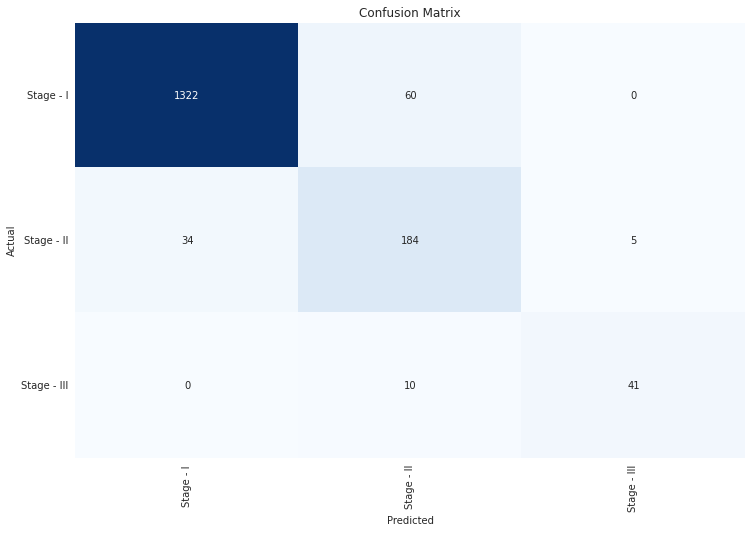

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.9749    0.9566    0.9657      1382
  Stage - II     0.7244    0.8251    0.7715       223
 Stage - III     0.8913    0.8039    0.8454        51

    accuracy                         0.9342      1656
   macro avg     0.8635    0.8619    0.8608      1656
weighted avg     0.9386    0.9342    0.9358      1656



In [34]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

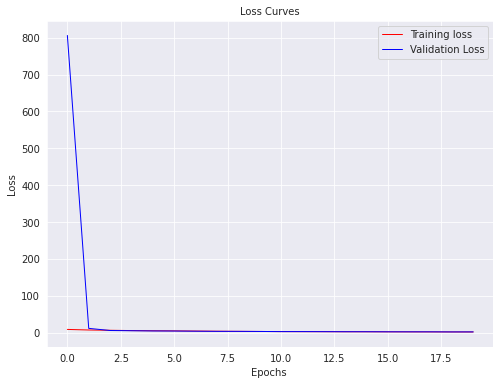

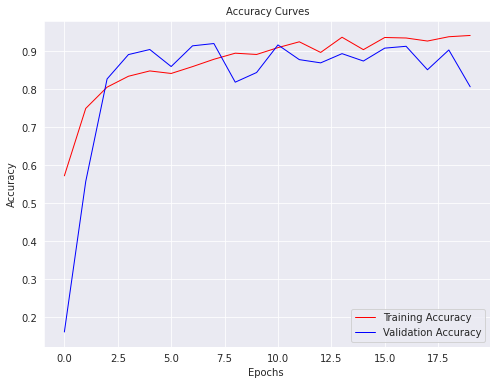

In [37]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()

In [14]:
tf.compat.v1.reset_default_graph()
img_shape=(img_size[0], img_size[1], 3)
model_name='MobileNetV3'
base_model=MobileNetV3Large(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

12683000/12683000 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.applications import MobileNetV3Large

In [15]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [16]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [20]:
new_history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  40  epochs
Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
75/75 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9887
 validation loss of  0.4956 is above lowest loss of  0.4151 keeping weights from epoch 34 as best weights
75/75 [==============================] - 33s 440ms/step - loss: 0.2284 - accuracy: 0.9887 - val_loss: 0.4956 - val_accuracy: 0.8753
Epoch 2/40
75/75 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9913
 validation loss of  0.6890 is above lowest loss of  0.4151 keeping weights from epoch 34 as best weights
75/75 [==============================] - 22s 296ms/step - loss: 0.2102 - accuracy: 0.9913 - val_loss: 0.6890 - val_accuracy: 0.8245
Epoch 3/40
75/75 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9907
 validation loss of  0.4717 is a

23/23 [==============================] - 5s 198ms/step
there were 111 errors in 1656 tests for an accuracy of  93.30


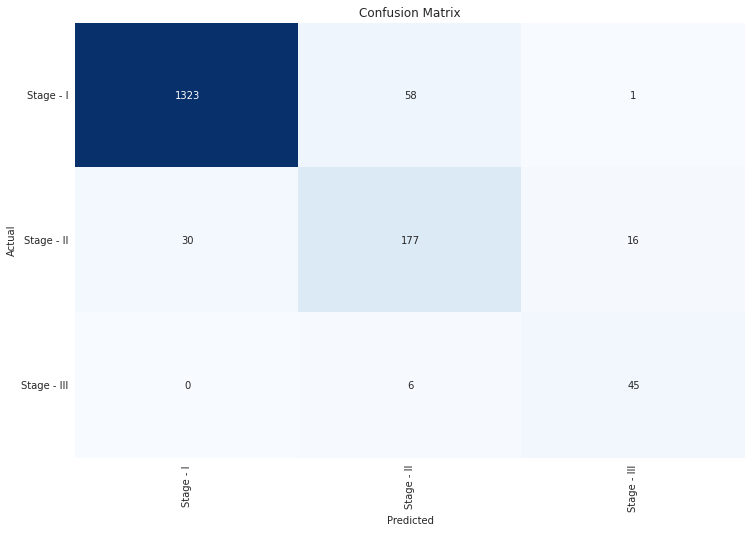

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.9778    0.9573    0.9675      1382
  Stage - II     0.7344    0.7937    0.7629       223
 Stage - III     0.7258    0.8824    0.7965        51

    accuracy                         0.9330      1656
   macro avg     0.8127    0.8778    0.8423      1656
weighted avg     0.9373    0.9330    0.9347      1656



In [23]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

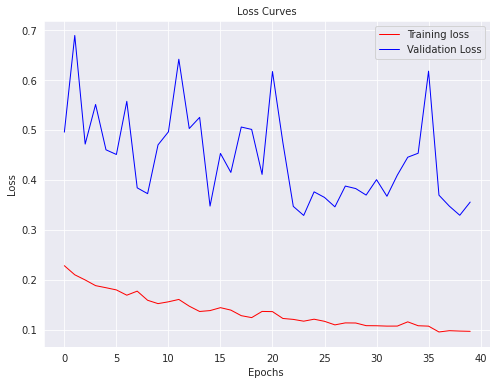

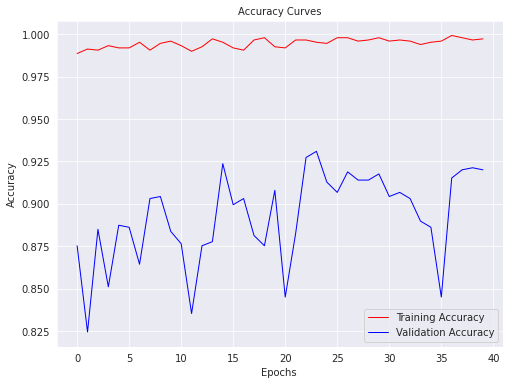

In [27]:
plt.figure(figsize=[8,6])
plt.plot(new_history.history['loss'],'r',linewidth=1.0)
plt.plot(new_history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(new_history.history['accuracy'],'r',linewidth=1.0)
plt.plot(new_history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()

In [59]:
from tensorflow.keras.applications import NASNetLarge
img_shape=(img_size[0], img_size[1], 3)
model_name='NASNetLarge'
base_model=tf.keras.applications.NASNetLarge(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

ValueError: ignored

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
epochs=100
ask_epoch=40
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
img_shape=(img_size[0], img_size[1], 3)
model_name='ResNet50'
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
epochs=100
ask_epoch=40
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

23/23 [==============================] - 6s 231ms/step
there were 442 errors in 1656 tests for an accuracy of  73.31


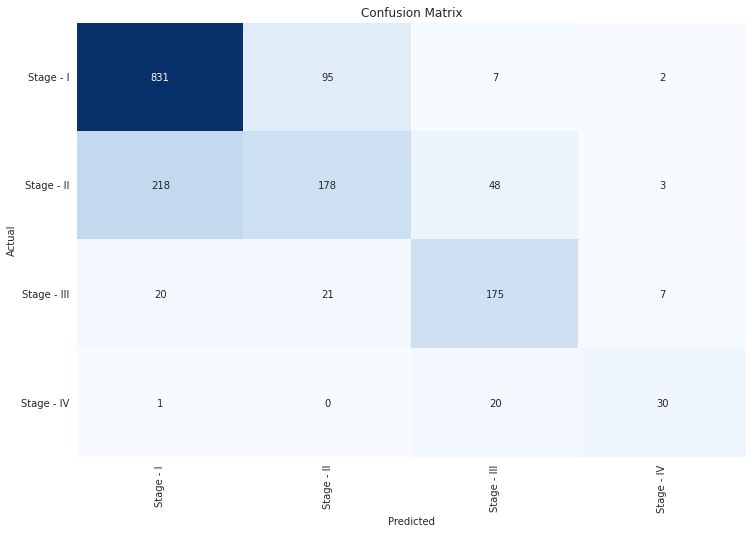

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.7766    0.8888    0.8289       935
  Stage - II     0.6054    0.3982    0.4804       447
 Stage - III     0.7000    0.7848    0.7400       223
  Stage - IV     0.7143    0.5882    0.6452        51

    accuracy                         0.7331      1656
   macro avg     0.6991    0.6650    0.6736      1656
weighted avg     0.7182    0.7331    0.7172      1656



In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

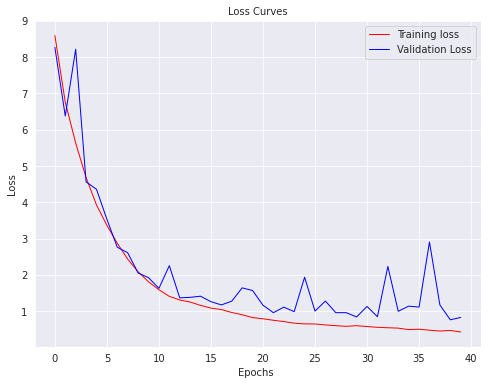

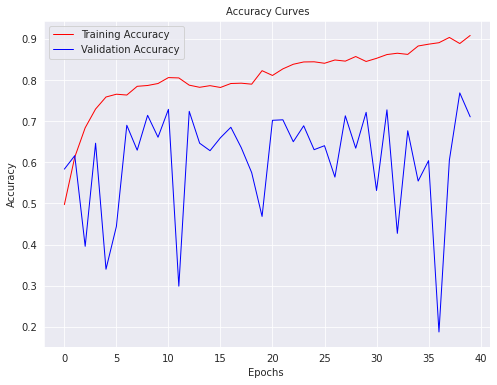

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
img_shape=(img_size[0], img_size[1], 3)
model_name='VGG16'
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

58889256/58889256 [==============================] - 3s 0us/step


In [13]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [15]:
epochs=100
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [16]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 5.6148 - accuracy: 0.4420 
 validation loss of 10.9556 is below lowest loss, saving weights from epoch 1   as best weights
75/75 [==============================] - 1383s 18s/step - loss: 5.6148 - accuracy: 0.4420 - val_loss: 10.9556 - val_accuracy: 0.0424
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 4.1278 - accuracy: 0.5193
 validation loss of  5.1091 is below lowest loss, saving weights from epoch 2   as best weights
75/75 [==============================] - 30s 392ms/step - loss: 4.1278 - accuracy: 0.5193 - val_loss: 5.1091 - val_accuracy: 0.8390
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 3.4065 - accuracy: 0.5353
 validation loss of  3.2689 is below lowest loss, saving weights from epoch 3   as best weights


23/23 [==============================] - 9s 420ms/step
there were 206 errors in 1656 tests for an accuracy of  87.56


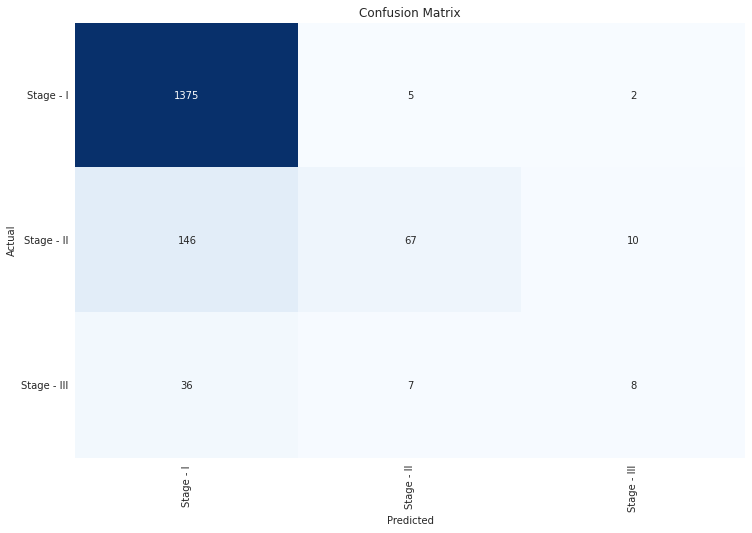

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.8831    0.9949    0.9357      1382
  Stage - II     0.8481    0.3004    0.4437       223
 Stage - III     0.4000    0.1569    0.2254        51

    accuracy                         0.8756      1656
   macro avg     0.7104    0.4841    0.5349      1656
weighted avg     0.8635    0.8756    0.8476      1656



In [18]:
1def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

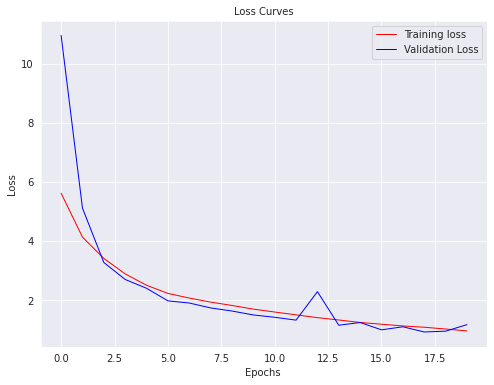

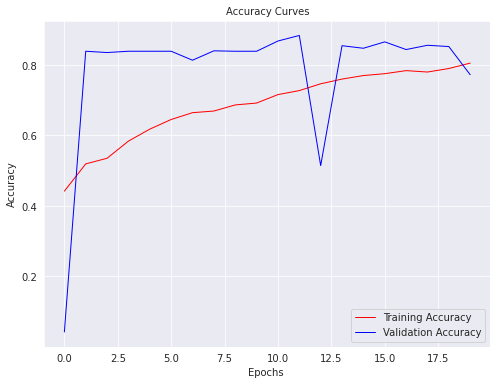

In [19]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()

In [22]:
from tensorflow.keras.applications import InceptionV3
img_shape=(img_size[0], img_size[1], 3)
model_name='Googlenet'
base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

87910968/87910968 [==============================] - 5s 0us/step


In [23]:

class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [24]:
epochs=100
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [25]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 8.4637 - accuracy: 0.5720
 validation loss of 806.3221 is below lowest loss, saving weights from epoch 1   as best weights
75/75 [==============================] - 35s 341ms/step - loss: 8.4637 - accuracy: 0.5720 - val_loss: 806.3221 - val_accuracy: 0.1610
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 6.9303 - accuracy: 0.7493
 validation loss of 11.3387 is below lowest loss, saving weights from epoch 2   as best weights
75/75 [==============================] - 26s 349ms/step - loss: 6.9303 - accuracy: 0.7493 - val_loss: 11.3387 - val_accuracy: 0.5569
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 6.1444 - accuracy: 0.8053
 validation loss of  5.5252 is below lowest loss, saving weights from epoch 3   as best weigh

23/23 [==============================] - 5s 209ms/step
there were 146 errors in 1656 tests for an accuracy of  91.18


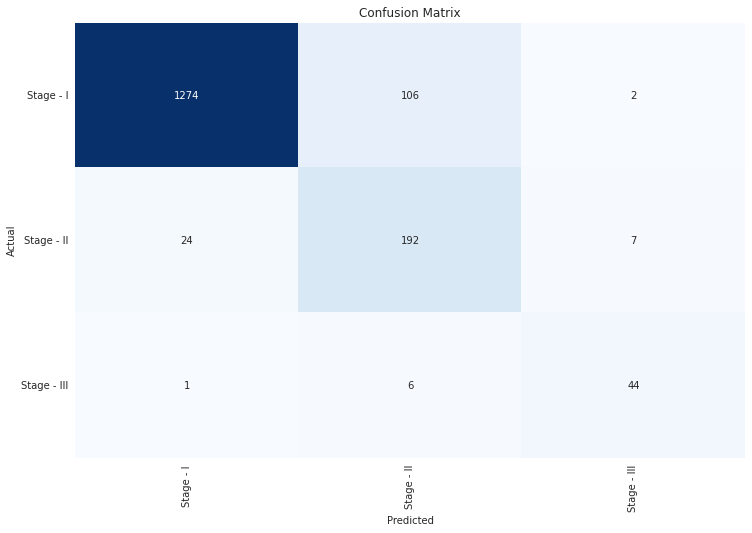

Classification Report:
----------------------
               precision    recall  f1-score   support

   Stage - I     0.9808    0.9219    0.9504      1382
  Stage - II     0.6316    0.8610    0.7287       223
 Stage - III     0.8302    0.8627    0.8462        51

    accuracy                         0.9118      1656
   macro avg     0.8142    0.8819    0.8417      1656
weighted avg     0.9291    0.9118    0.9173      1656



In [28]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

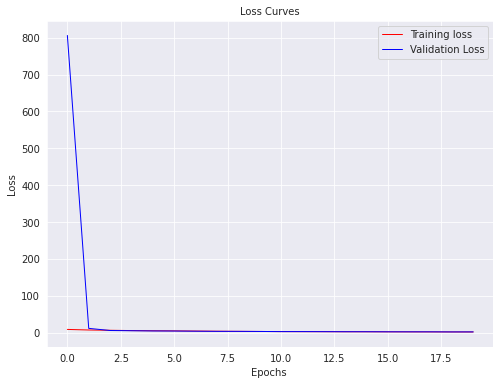

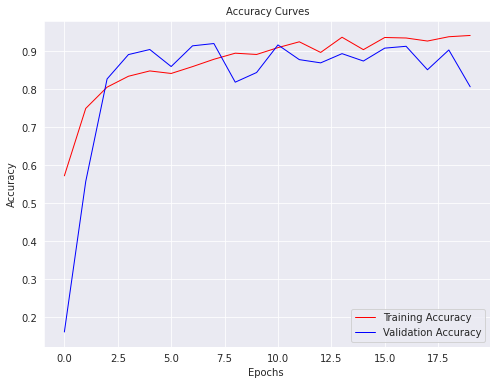

In [27]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
plt.show()
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves',fontsize=10) 
plt.show()